In [3]:
import seaborn as sns

from scipy.stats import kurtosis, skew

from rcv_distribution import *
from rcv_dimensionality import *

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'CAROL J. BECKER': 0.0, 'DAVID B WHEELER': 0.7100803627538298, 'DAVID PASCOE': 1.2954323143817301, 'DOUGLAS SEMBLA': 3.0}


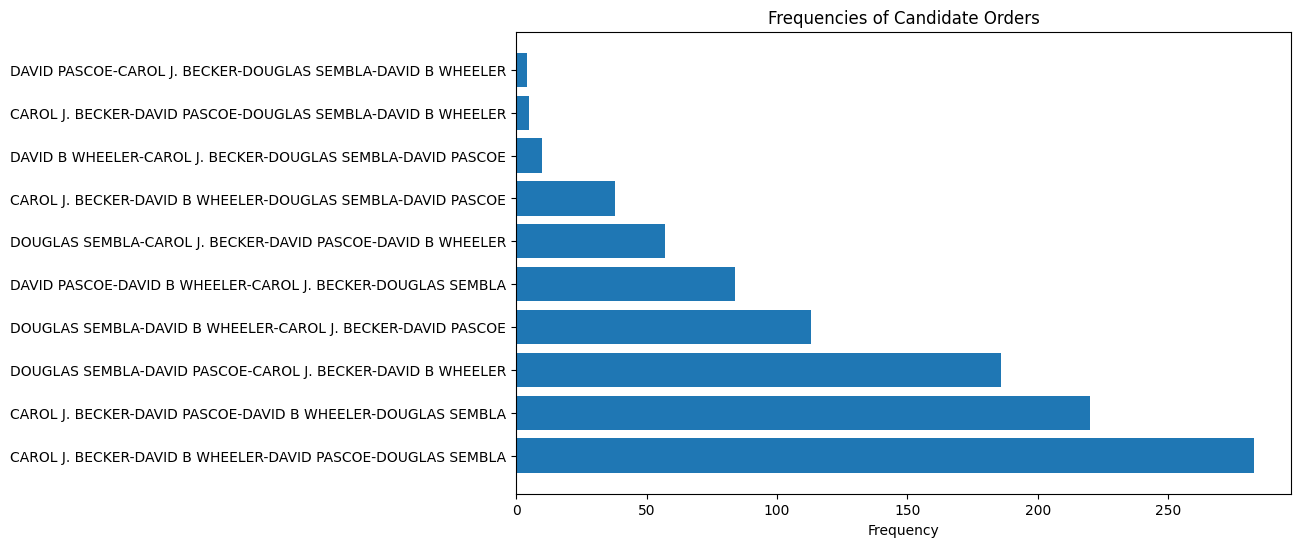

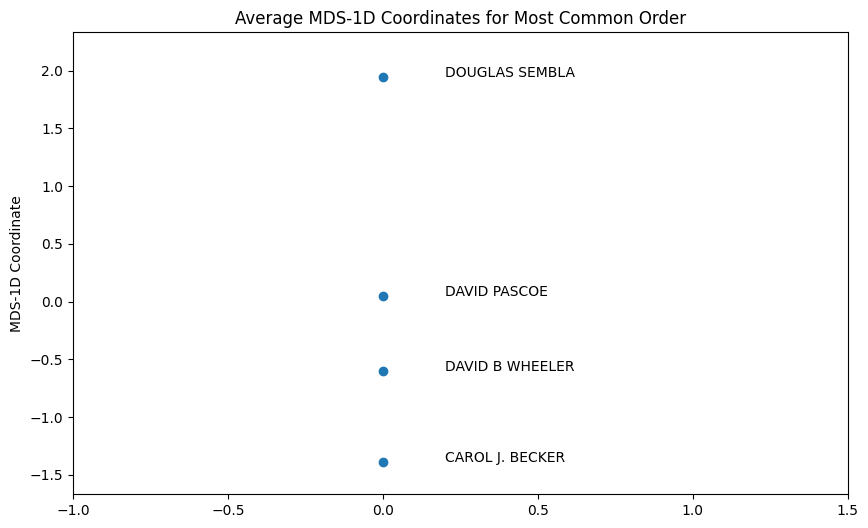

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_learning/rcv_dimensionality.py:170: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Bimodality coefficient: 0.6676896916640402


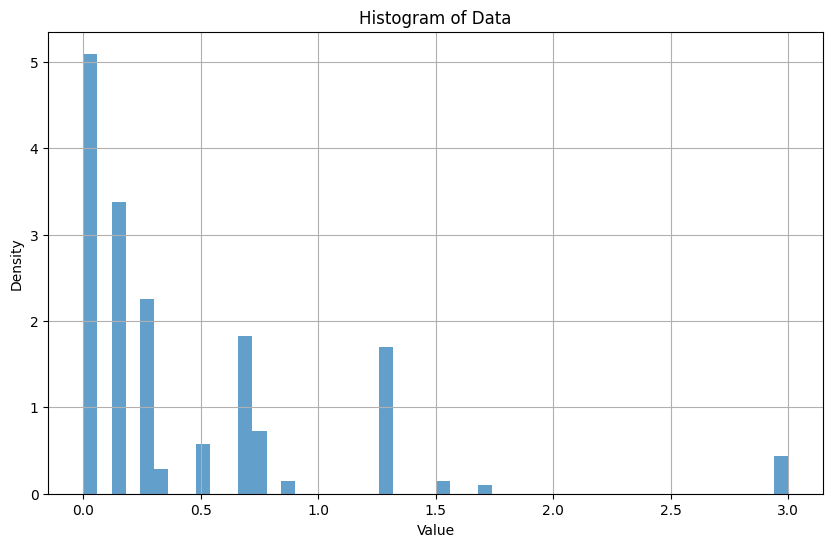

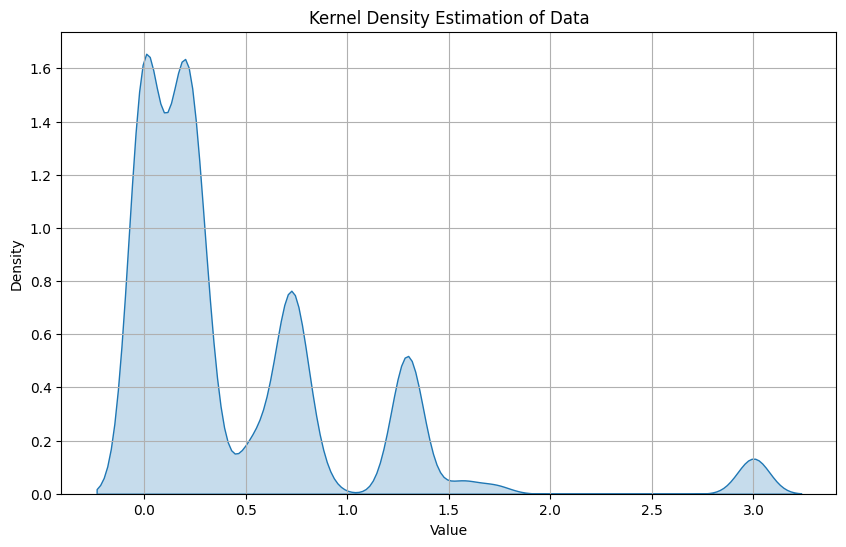

In [5]:
# Test the function with a custom CSV file
csv = "../rcv_elections_database/single/Hawaii"

# Perform the RCV analysis
test = perform_rcv_analysis(csv, n_runs=1000)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
print("Normalized distances:", get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names))
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(csv)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Calculate skewness and kurtosis
g = skew(data_points)
k = kurtosis(data_points)

# Calculate bimodality coefficient
n = len(data_points)
bimodality = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))
print("Bimodality coefficient:", bimodality)

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()